# API Example: UpSet Plot
This notebook demonstrates how to use the UpSet plot to visualize feature interactions in a model. The UpSet plot is a powerful tool for understanding the relationships between features and their contributions to model predictions.

In [1]:
import shapiq

{"shapiq version": shapiq.__version__}

{'shapiq version': '1.2.3.9000'}

First we load some data, train a model and get an explanation for a single prediction:

In [2]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# get the data
x_data, y_data = shapiq.datasets.load_california_housing(to_numpy=False)
feature_names = list(x_data.columns)  # get the feature names
n_features = len(feature_names)
print("Features in the dataset:", feature_names)

# train a model
x_data, y_data = x_data.values, y_data.values  # transform to numpy arrays
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
model = XGBRegressor(random_state=42, max_depth=4, n_estimators=50)
model.fit(x_train, y_train)

# evaluate the model
mse = mean_squared_error(y_test, model.predict(x_test))
r2 = r2_score(y_test, model.predict(x_test))
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

# get interaction explanations
x_explain = x_test[2]  # get the first sample
explainer = shapiq.TabularExplainer(model, data=x_test, index="FSII", max_order=2, random_state=42)
explanation = explainer.explain(x_explain, budget=200)
print(explanation)

Features in the dataset: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Mean Squared Error: 0.24441967828624162
R2 Score: 0.8134783244431429
InteractionValues(
    index=FSII, max_order=2, min_order=0, estimated=True, estimation_budget=200,
    n_players=8, baseline_value=2.058321475982666,
    Top 10 interactions:
        (): 2.058321475982666
        (7,): 1.3230917615308475
        (5,): 0.41396579651520565
        (6, 7): 0.31170815979317307
        (1, 7): 0.2677731059707886
        (2, 5): 0.21734065280970352
        (1,): 0.1495932032414866
        (1, 5): 0.1408695640429562
        (0,): -0.20034254899134368
        (6,): -0.532954309745451
)


/Users/max/PycharmProjects/shapiq/shapiq/approximator/regression/_base.py:602: RuntimeWarning: divide by zero encountered in matmul
  phi = np.linalg.solve(X.T @ WX, WX.T @ y)
/Users/max/PycharmProjects/shapiq/shapiq/approximator/regression/_base.py:602: RuntimeWarning: overflow encountered in matmul
  phi = np.linalg.solve(X.T @ WX, WX.T @ y)
/Users/max/PycharmProjects/shapiq/shapiq/approximator/regression/_base.py:602: RuntimeWarning: invalid value encountered in matmul
  phi = np.linalg.solve(X.T @ WX, WX.T @ y)


## Visualizing Feature Interactions with an UpSet Plot

Once we compute Shapley interaction values, a key challenge is interpreting the many combinations of interacting features. While single-feature attributions are relatively easy to visualize (e.g., via bar plots or force plots), higher-order interactions require more expressive visualizations.

The **UpSet plot** is a powerful technique for visualizing intersecting sets—in our case, sets of interacting features. Originally introduced by Lex et al. (2014), the UpSet plot replaces traditional Venn diagrams and is especially useful when dealing with more than three sets.

In the context of model explanations, we use the UpSet plot to:
- Show the **most important interactions** (by absolute interaction value) as vertical bars in the top portion of the plot.
- Present the **interacting features** in the bottom matrix, where each column corresponds to a feature set and each row to a specific feature.
- Optionally color-code the interactions based on whether they contribute positively or negatively to the model’s output.

This visualization helps us understand **which combinations of features** most strongly drive predictions and whether their joint contribution is **synergistic** (positive) or **antagonistic** (negative).

Let’s plot the top interactions for our example prediction:


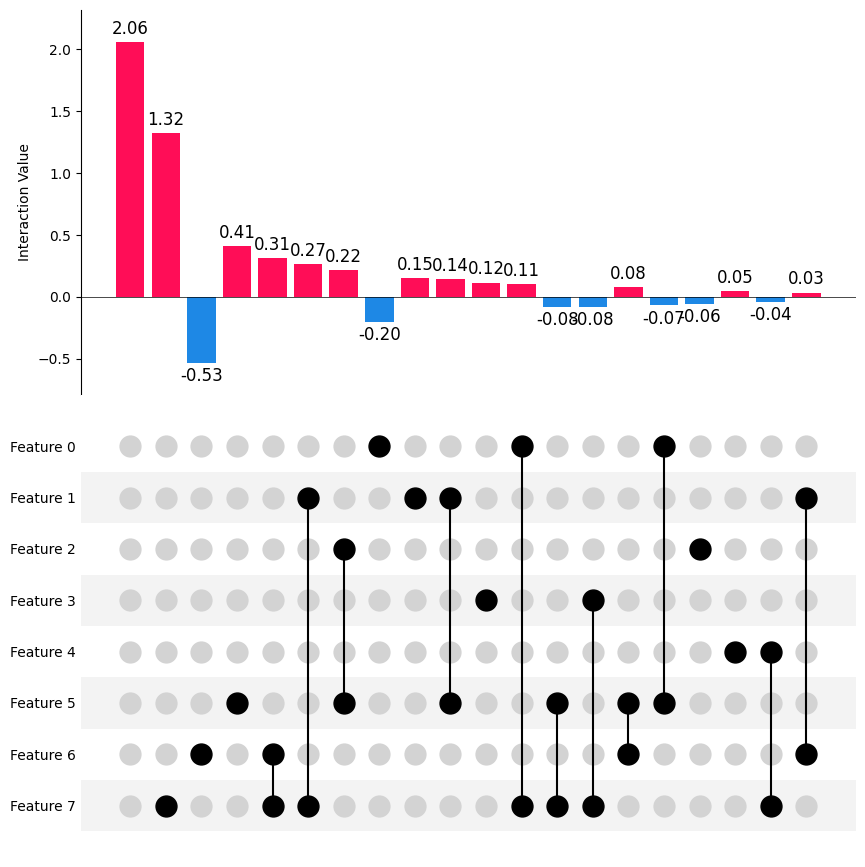

In [3]:
# plot the upset plot
explanation.plot_upset()

**Interpretation of the above UpSet Plot:**
Most interactions in the plot are positive (pink bars), meaning they increase the model’s prediction. A few interactions are negative (blue bars), indicating they reduce the prediction. The strongest positive contributions comes from the empty prediction (a value of +2.06). Feature 7 has the highest individual contribution (+1.32), while the largest negative individual contribution is feature 6 with around –0.53. Features 6 and 7 have the largest positive interaction (+0.31).


## Customizing the UpSet Plot
The UpSet plot can be customized in several ways:

1. **Number of Interactions**: You can specify how many interactions to display. By default, the top 20 interactions are shown, but you can adjust this to show more or fewer interactions.
2. **Coloring the Matrix**: The matrix can be color-coded based on interaction values (red for positive, blue for negative) or displayed in black and white. This helps to quickly identify the nature of the interactions.
3. **Feature Names**: You can provide custom names for the features in the plot. If not provided, default names will be used.
4. **All Features vs. Top Interactions**: You can choose to display all features or only those present in the top interactions. This is useful for focusing on the most relevant features.
5. **Figure Size**: You can adjust the figure size to fit your needs.
6. **Font Size**: You can adjust the font size of the axis and feature names using `matplotlib`'s `rcParams`.

### Number of Interactions
The number of interactions to display can be specified to show more or less interactions.

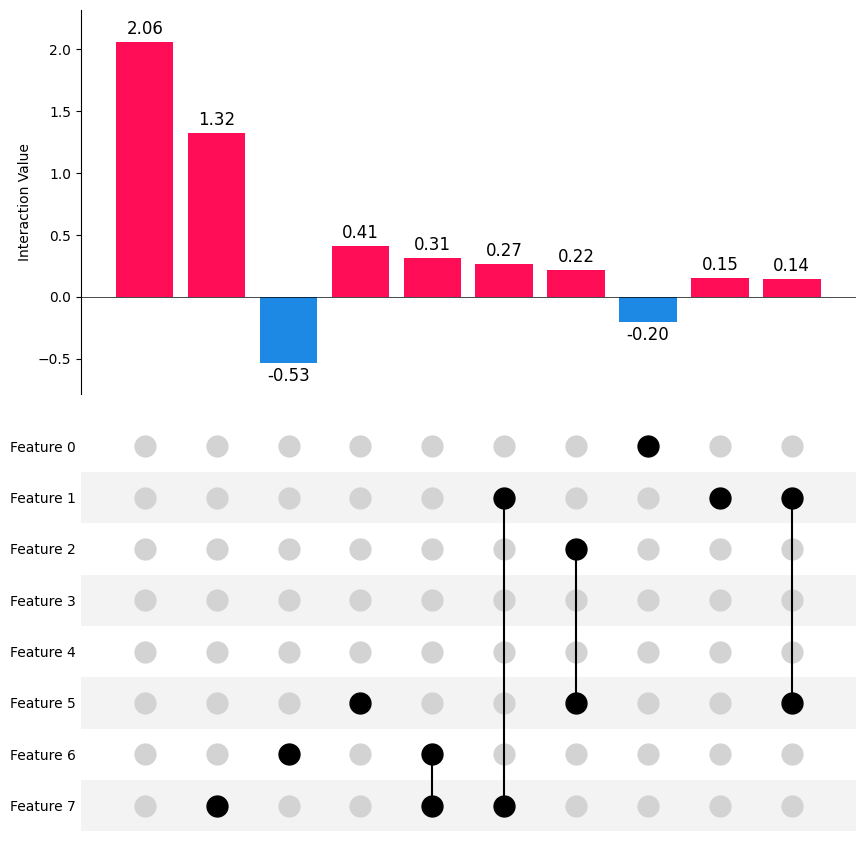

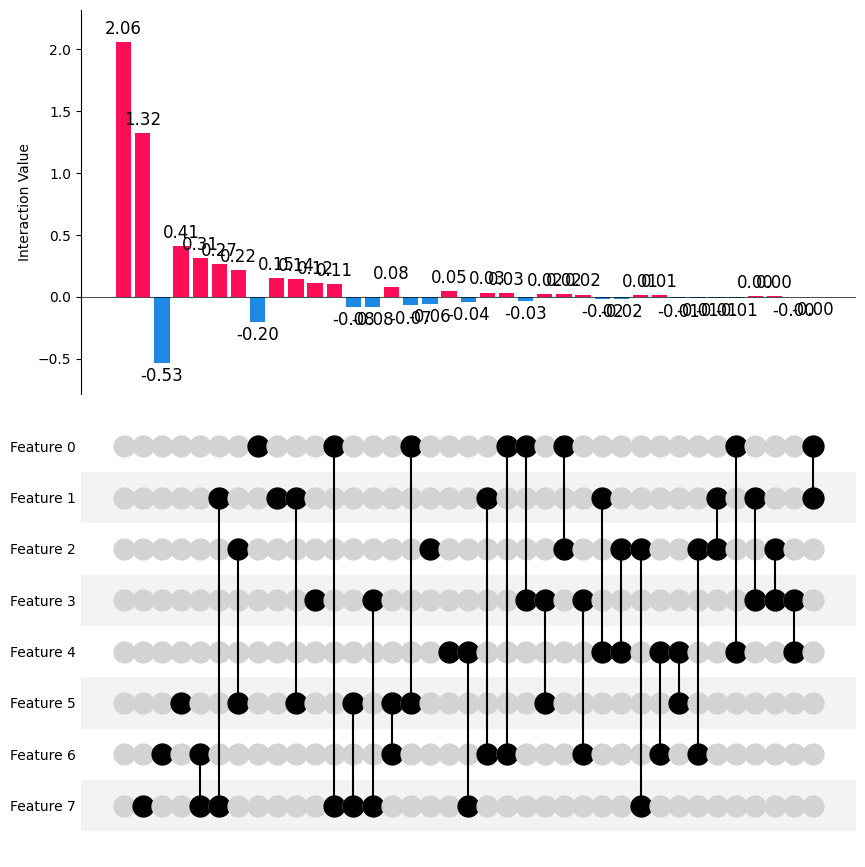

In [4]:
# specify the number of interactions to plot
explanation.plot_upset(n_interactions=10, show=True)
explanation.plot_upset(n_interactions=40, show=True)

### Color the Matrix
You can also choose to color the matrix based on the interaction values (red for positive values and blue for negative values). By default, the matrix is colored in black and white.

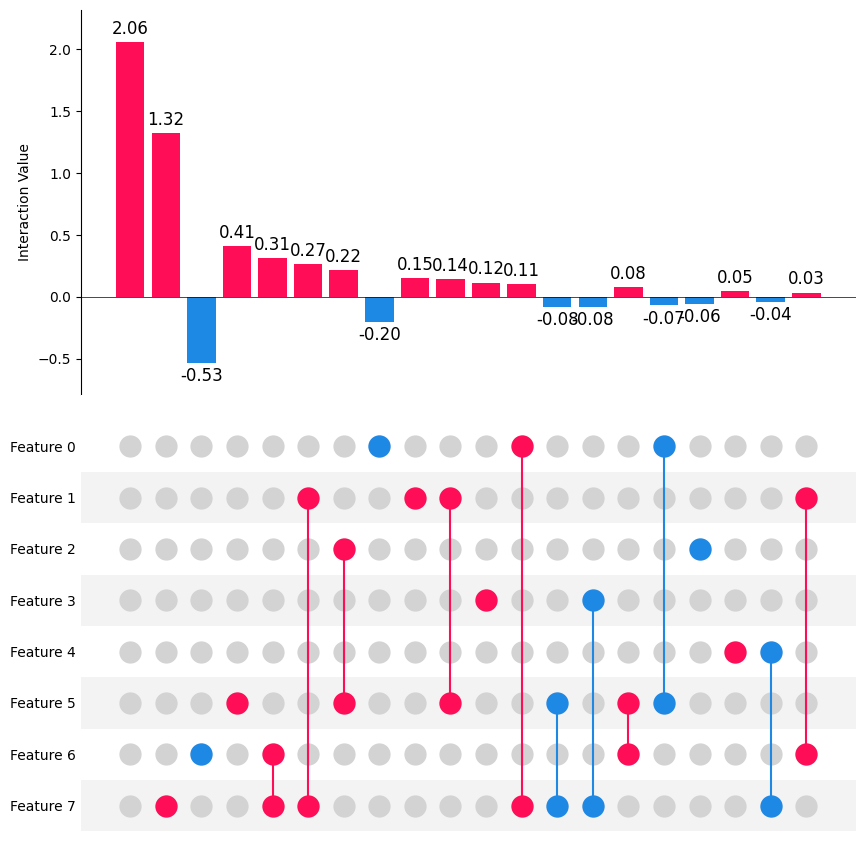

In [5]:
explanation.plot_upset(
    color_matrix=True,
)

### Feature Names
If you have feature names that you want to use in the plot, you can provide them as a list. If not provided, default names will be used.

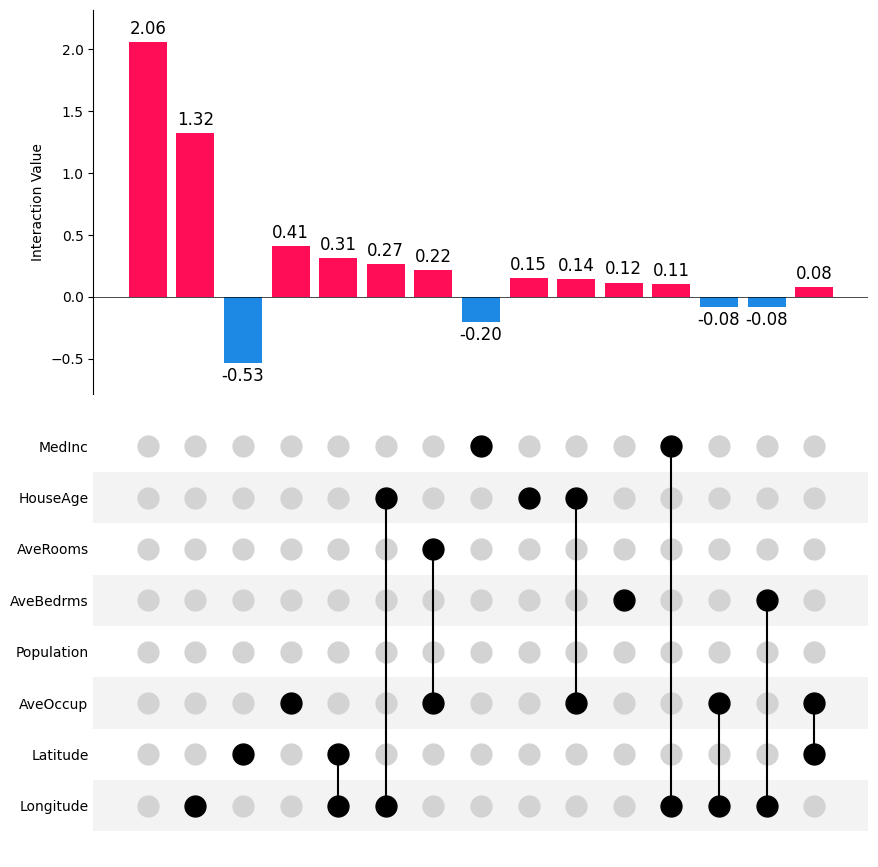

In [6]:
explanation.plot_upset(
    feature_names=feature_names,
    n_interactions=15,
)

### All Features vs. Top Interactions
You can choose to add all features (players) to the matrix part of the plot or only the ones that are present in the top interactions. By default, all features are shown. This is particularly useful when you want to focus on the most relevant features in the context of the top interactions, or if you have many features and want to reduce clutter in the plot. The following code will reduce the number of interactions to the top 7 interactions and will only show the features that are present in those interactions in the matrix part of the plot. Notice how the first plot contains all 7 features, while the second plot only contains less.

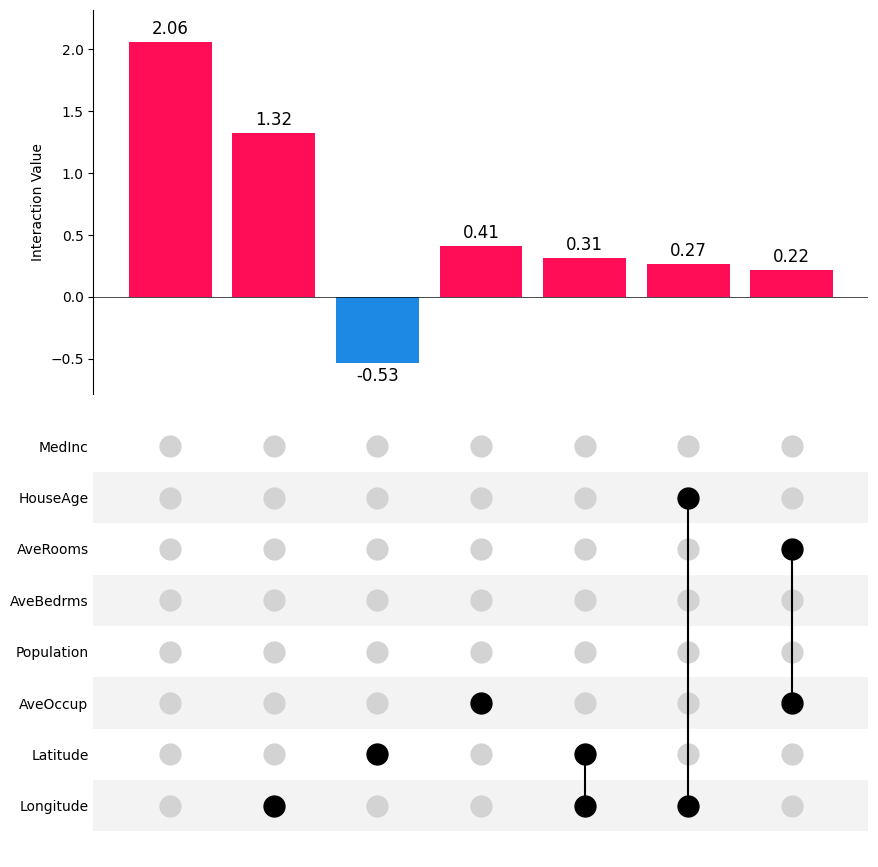

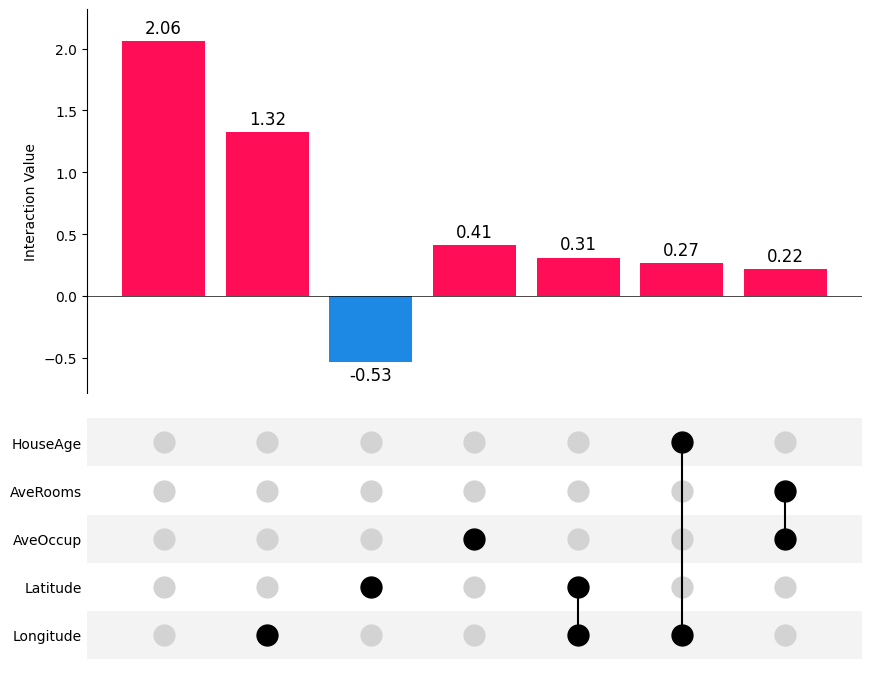

In [7]:
explanation.plot_upset(
    all_features=True,
    show=True,
    n_interactions=7,
    feature_names=feature_names,
)

explanation.plot_upset(
    all_features=False,
    show=True,
    n_interactions=7,
    feature_names=feature_names,
)

### Adjusting the figure size
You can also adjust the figure size of the plot by passing a tuple with the width and height of the figure in inches. By defaults, the size will be set automatically depending on the number of features.

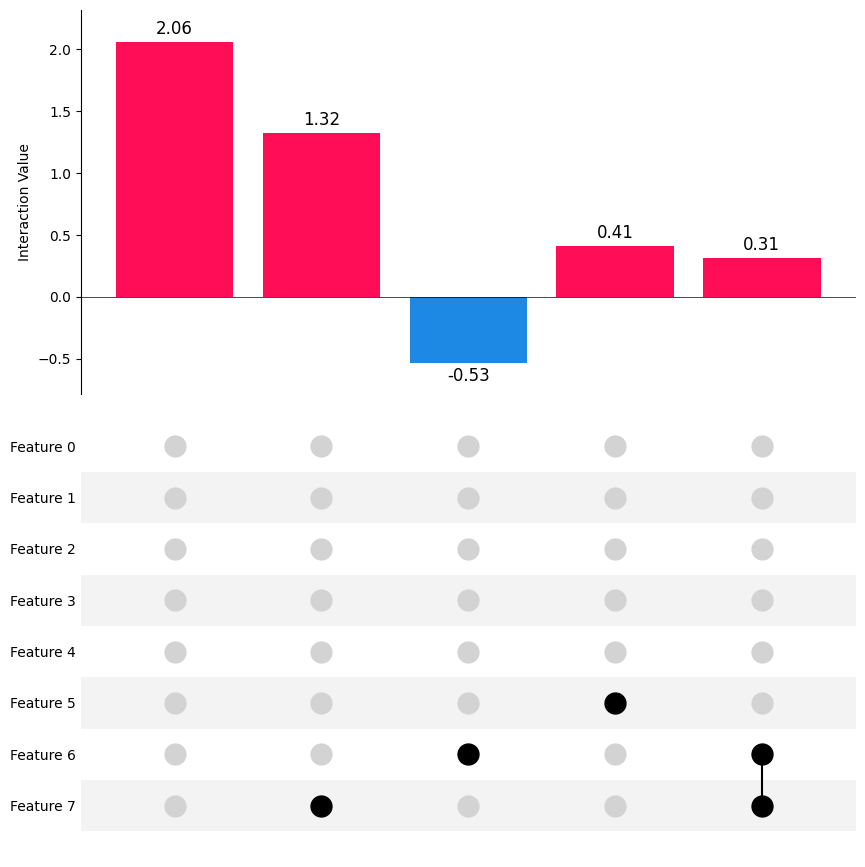

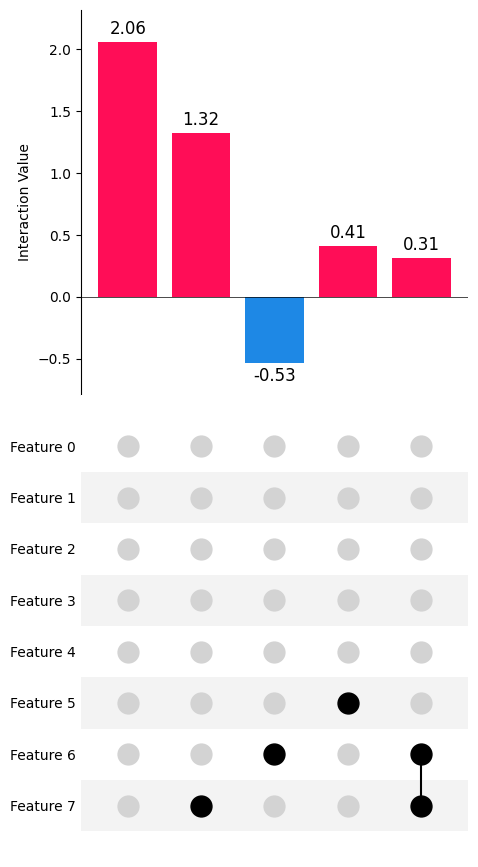

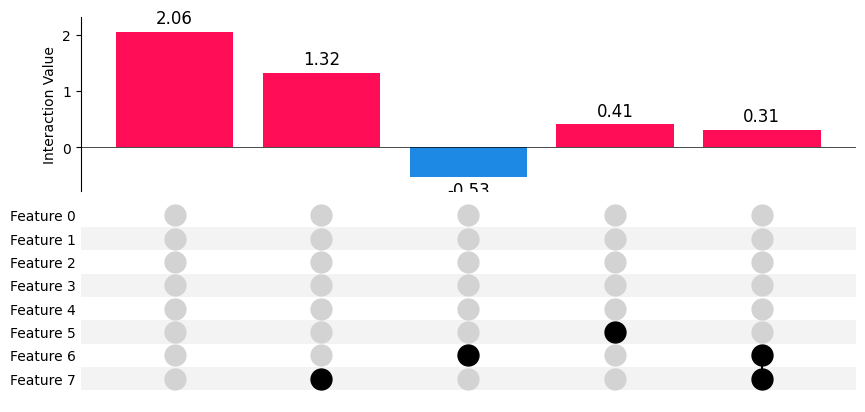

In [8]:
explanation.plot_upset(
    show=True,
    n_interactions=5,
)

explanation.plot_upset(
    show=True,
    n_interactions=5,
    figsize=(5, None),  # height is set automatically
)

explanation.plot_upset(
    show=True,
    n_interactions=5,
    figsize=(None, 5),  # width is set automatically
)

### Adjusting the Font Size
You can adjust the font size of the axis and the feature (player) names by using `matplotlib`'s `rcParams` to set the font size globally.

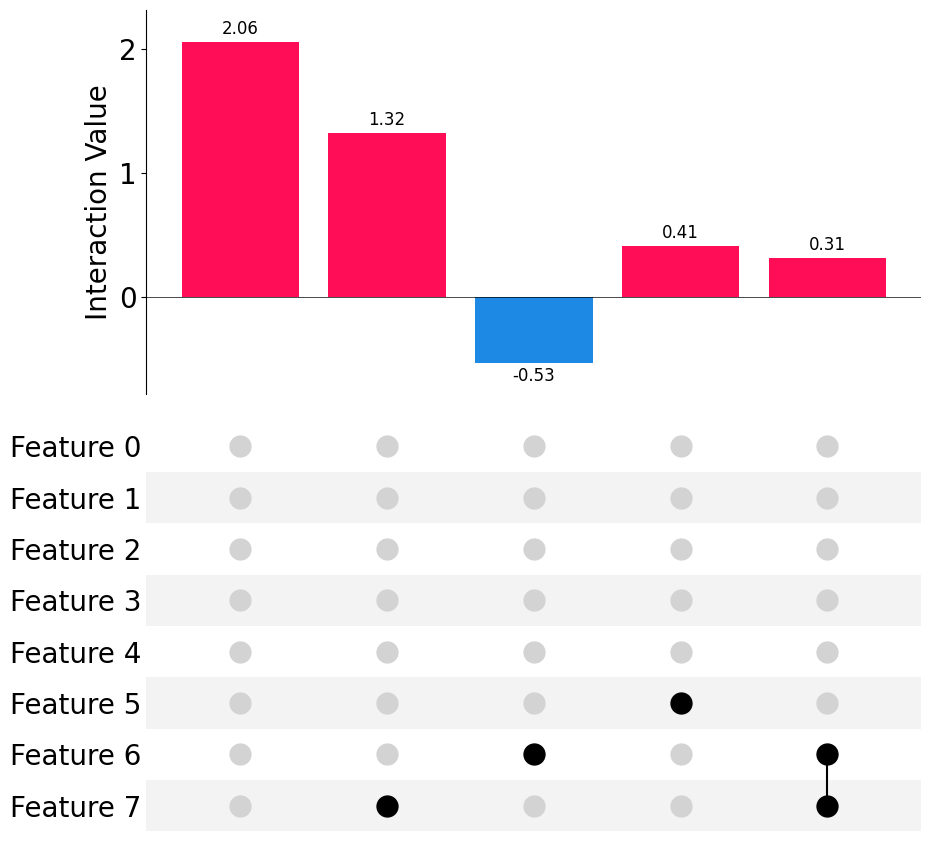

In [9]:
import matplotlib as mpl

mpl.rcParams.update({"font.size": 20})
explanation.plot_upset(
    show=True,
    n_interactions=5,
)

## References

Alexander Lex, Nils Gehlenborg, Hendrik Strobelt, Romain Vuillemot, Hanspeter Pfister. UpSet: Visualization of Intersecting Sets IEEE Transactions on Visualization and Computer Graphics (InfoVis), 20(12): 1983--1992, doi:10.1109/TVCG.2014.2346248, 2014.

